In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from os.path import splitext
import glob


In [1]:
import tensorflow as tf
#from tensorflow import keras
#from keras.models import *
#from keras.layers import *
#from keras.optimizers import *
from keras import backend as keras
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.layers as tfl
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,UpSampling2D,Concatenate,Input,Softmax
from tensorflow.keras import Model
#from tensorflow.keras.callbacks import ModelCheckpoint
#from PIL import Image
#from os.path import splitext
from keras import backend as K
import albumentations as A
import glob

In [2]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

filter_scale = 5/4

def build_model(inputsize=(256,256,3),classes=None):
    inputs = tf.keras.Input(shape=(inputsize))

    conv = tfl.Conv2D(32*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv1')(inputs)
    x=tfl.BatchNormalization()(conv)
    x=tfl.LeakyReLU()(x)
    x1 = tfl.Conv2D(32*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv2')(x)
    x=tfl.BatchNormalization()(x1)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)

    x = tfl.Conv2D(64*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv3')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x2 = tfl.Conv2D(64*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv4')(x)
    x=tfl.BatchNormalization()(x2)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), name='MaxPool2')(x)

    x = tfl.Conv2D(128*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv5')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x3 = tfl.Conv2D(128*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv6')(x)
    x=tfl.BatchNormalization()(x3)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool3')(x)

    
    x = tfl.Conv2D(256*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv7')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(256*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv8')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(256*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv9')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(128*filter_scale, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x3], axis=3)
    
    x = tfl.Conv2D(128*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv10')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(128*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv11')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2DTranspose(64*filter_scale, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x2], axis=3)

    x = tfl.Conv2D(64*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv12')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(64*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv13')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(32*filter_scale, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x1], axis=3)

    x = tfl.Conv2D(32*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv14')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(32*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv15')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    outputs = tfl.Conv2D(classes, (1, 1), padding="same", activation='sigmoid', name='Outputs')(x)
    final_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    final_model.summary()
    return final_model

In [3]:
mymodel=build_model(classes=1)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 40) 1120        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 40) 160         Conv1[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 40) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [4]:
mymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004),
                loss=[dice_coef_loss],
                metrics = [dice_coef,tf.metrics.MeanIoU(num_classes = 2),tf.metrics.binary_accuracy]
                )

In [5]:
mymodel.load_weights("C:/Users/punti/pedestrian/pedestrian_good_model.h5")

In [14]:
x_test = cv2.imread( "C:/Users/punti/pedestrian/Webp.net-resizeimage (7).png", cv2.COLOR_BGR2RGB)

In [15]:
x_test = cv2.resize(x_test, (256, 256),interpolation = cv2.INTER_AREA)
x_test = cv2.cvtColor(x_test, cv2.COLOR_BGR2RGB)
x_test = x_test/255
x_test=np.array(x_test).reshape(1,256,256,3)

In [16]:
ypred = mymodel.predict(x_test)

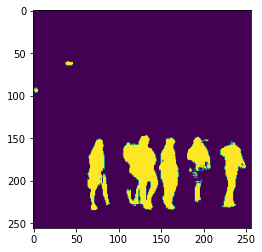

In [17]:
plt.imshow(ypred[0])

In [2]:
IMG_WIDTH=400
IMG_HEIGHT=400

In [3]:
def SliceToHalf(img):
    
    border = int(len(img[1,:])/2)
    image1 = img[:,:border]
    image2 = img[:,border:]
    del img
    
    return image1, image2

In [18]:
import math
def ApplyGammaCorrection(img):
    # convert img to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # compute gamma = log(mid*255)/log(mean)
    mid = 0.5
    mean = np.mean(gray)
    gamma = math.log(mid*255)/math.log(mean)

    # do gamma correction
    img_gamma1 = np.power(img, gamma).clip(0,255).astype(np.uint8)
    del gray
    
    return img_gamma1

In [4]:
def ProcessImages(left_img,right_img):
    
    left_img=cv2.resize(left_img, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
    right_img=cv2.resize(right_img, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
    left_img = left_img.astype('float32')
    right_img = right_img.astype('float32')
    left_img /= 255 
    right_img /= 255 
    
    return left_img,right_img

In [4]:
len(os.listdir("D:/pedestrian/processed_dataset/gamma_crop_dataset/new_image_dataset/"))

6950

In [5]:
len(os.listdir("D:/pedestrian/processed_dataset/gamma_crop_dataset/new_mask_dataset/"))

6950

In [5]:
def create_dataset(img_folder,write_folder,name,idx):
   
    for dir1 in os.listdir(img_folder):
        for file in tqdm(os.listdir(os.path.join(img_folder, dir1))):
            if file.endswith("_leftImg8bit.png"):
                image_path= os.path.join(img_folder, dir1,  file)
                image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
                image = ApplyGammaCorrection(image)
                image=np.array(image)
                left_img,right_img=SliceToHalf(image)
                left_img,right_img=ProcessImages(left_img,right_img)
                
                cv2.imwrite(os.path.join(write_folder , str(name)+str(idx)+'.png'), 255*left_img)
                idx+=1
                cv2.imwrite(os.path.join(write_folder , str(name)+str(idx)+'.png'), 255*right_img)
                idx+=1 

                del left_img
                del right_img
                
                
            """if file.endswith("_instanceIds.png"):
                image_path= os.path.join(img_folder, dir1,  file)
                image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
                image=np.array(image)
                left_img,right_img=SliceToHalf(image)
                left_img,right_img=ProcessImages(left_img,right_img)
                
                cv2.imwrite(os.path.join(write_folder , str(name)+str(idx)+'.png'), 255*left_img)
                idx+=1
                cv2.imwrite(os.path.join(write_folder , str(name)+str(idx)+'.png'), 255*right_img)
                idx+=1 

                del left_img
                del right_img"""
            
            if file.endswith("_gtFine_color.png"):
                image_path= os.path.join(img_folder, dir1,  file)
                image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
                image=np.array(image)
                left_img,right_img=SliceToHalf(image)
                left_img,right_img=ProcessImages(left_img,right_img)
                
                cv2.imwrite(os.path.join(write_folder , str(name)+str(idx)+'.png'), 255*left_img)
                idx+=1
                cv2.imwrite(os.path.join(write_folder , str(name)+str(idx)+'.png'), 255*right_img)
                idx+=1 
                
                del left_img
                del right_img
            
                
    return idx

In [25]:
index=create_dataset(r'D:/pedestrian/dataset/leftImg8bit_trainvaltest/leftImg8bit/train/rest_citys',"D:/pedestrian/processed_dataset/new_image_dataset/","image",0)
index=create_dataset(r'D:/pedestrian/dataset/leftImg8bit_trainvaltest/leftImg8bit/val',"D:/pedestrian/processed_dataset/new_image_dataset/","image",index)
print(index)


100%|████████████████████████████████████████████████████████████████████████████████| 174/174 [01:20<00:00,  2.16it/s]

6950


In [31]:
index= create_dataset(r'D:/pedestrian/dataset/gtFine_trainvaltest/gtFine/train',"D:/pedestrian/processed_dataset/new_mask_dataset/","mask",0)
index= create_dataset(r'D:/pedestrian/dataset/gtFine_trainvaltest/gtFine/val',"D:/pedestrian/processed_dataset/new_mask_dataset/","mask",index)
print(index)

100%|███████████████████████████████████████████████████████████████████████████████| 696/696 [00:05<00:00, 122.88it/s]

6950


In [8]:
#index = create_dataset(r'D:/pedestrian/dataset/gtFine_trainvaltest/gtFine/train+val/train',"D:/pedestrian/dataset/all_class_masks","mask",0)
ind = create_dataset(r'D:/pedestrian/dataset/gtFine_trainvaltest/gtFine/train+val/val',"D:/pedestrian/dataset/all_class_masks","mask",index)

100%|████████████████████████████████████████████████████████████████████████████████| 696/696 [00:10<00:00, 68.04it/s]


In [ ]:
print(len(train_data))
print(len(val_data))

In [ ]:
img_dataset = train_data+val_data
print(len(img_dataset))

In [134]:
image_dataset = []

def create_dataset_extra(img_folder):
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            if file.endswith(".png"):
                image_path= os.path.join(img_folder, dir1,  file)
                image= cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image=np.array(image)
                image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
                image = image.astype('float32')
                image /= 255
                image_dataset.append(image)
            

In [135]:
#create_dataset_extra("C:/Users/punti/PennFudanPed/PennFudanPed/PNGImages/")
create_dataset_extra("C:/Users/punti/PennFudanPed/PennFudanPed/PedMasks/")

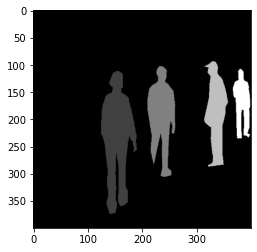

In [137]:
plt.imshow(image_dataset[45],cmap="gray")

In [138]:
for img in image_dataset:
    for i in range(0,400):
        for j in range(0,400):
            if img[i,j] != 0:
                img[i,j] = 1
            else:
                img[i,j] = 0
            

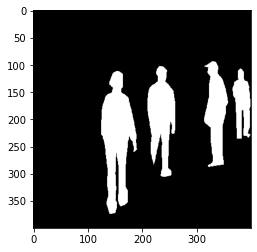

In [139]:
plt.imshow(image_dataset[45],cmap="gray")

In [62]:
 for img in image_dataset:   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

In [63]:
image_dataset[45].shape

(400, 400, 3)

In [ ]:
train_mask, train_mask_names = create_dataset_mask(r'D:/pedestrian/dataset/gtFine_trainvaltest/gtFine/train')
val_mask, val_mask_names     = create_dataset_mask(r'D:/pedestrian/dataset/gtFine_trainvaltest/gtFine/val')

In [ ]:
print(len(train_mask))
print(len(val_mask))

In [ ]:
plt.imshow(val_mask[400])

In [ ]:
mask_dataset = train_mask+val_mask
print(len(mask_dataset))

In [141]:
def saveDataset(path,dataset,name):
    for i in range(len(dataset)):
        cv2.imwrite(os.path.join(path , str(name)+str(i)+'.png'), 255*dataset[i])

#saveDataset("D:/pedestrian/processed_dataset/img_dataset/",img_dataset,"image")
#saveDataset("D:/pedestrian/processed_dataset/mask_dataset/",mask_dataset,"mask")

In [125]:
saveDataset("C:/Users/punti/PennFudanPed/PennFudanPed/resized_images",image_dataset,"image")

In [142]:
saveDataset("C:/Users/punti/PennFudanPed/PennFudanPed/resized_masks",image_dataset,"mask")